# MIIII

In [1]:
import jax.numpy as jnp
from jax import random
import jax
from oeis import oeis
from functools import partial
import optax
import esch
import src

In [2]:
# load the data
seq = oeis["A000040"]  # "A000040" is the sequence of prime numbers
data_conf, model_conf = src.get_conf()
alpha = src.alpha_fn(data_conf["n"])
rng, key = random.split(random.PRNGKey(0))
number_system = partial(src.base_n, data_conf["base"])
train_data, valid_data = src.data_fn("primes", seq, data_conf["n"], number_system)

In [3]:
# define the model associated functions
apply_fn = src.make_apply_fn(src.vaswani_fn)
loss_fn = src.make_loss_fn(apply_fn, alpha)
grad_fn = src.make_grad_fn(loss_fn)

In [4]:
# initialize the model and the training functions
params = src.init_fn(key, dict(**model_conf, len=train_data[0].shape[1]))
opt = optax.adam(1e-4)
opt_state = opt.init(params)
update_fn = src.make_update_fn(opt)

In [5]:
# train the model
step_fn = src.make_step_fn(grad_fn, update_fn, loss_fn, train_data, valid_data)
state, losses = src.train_fn(step_fn, params, opt_state, 1000)

Array(0., dtype=float32)

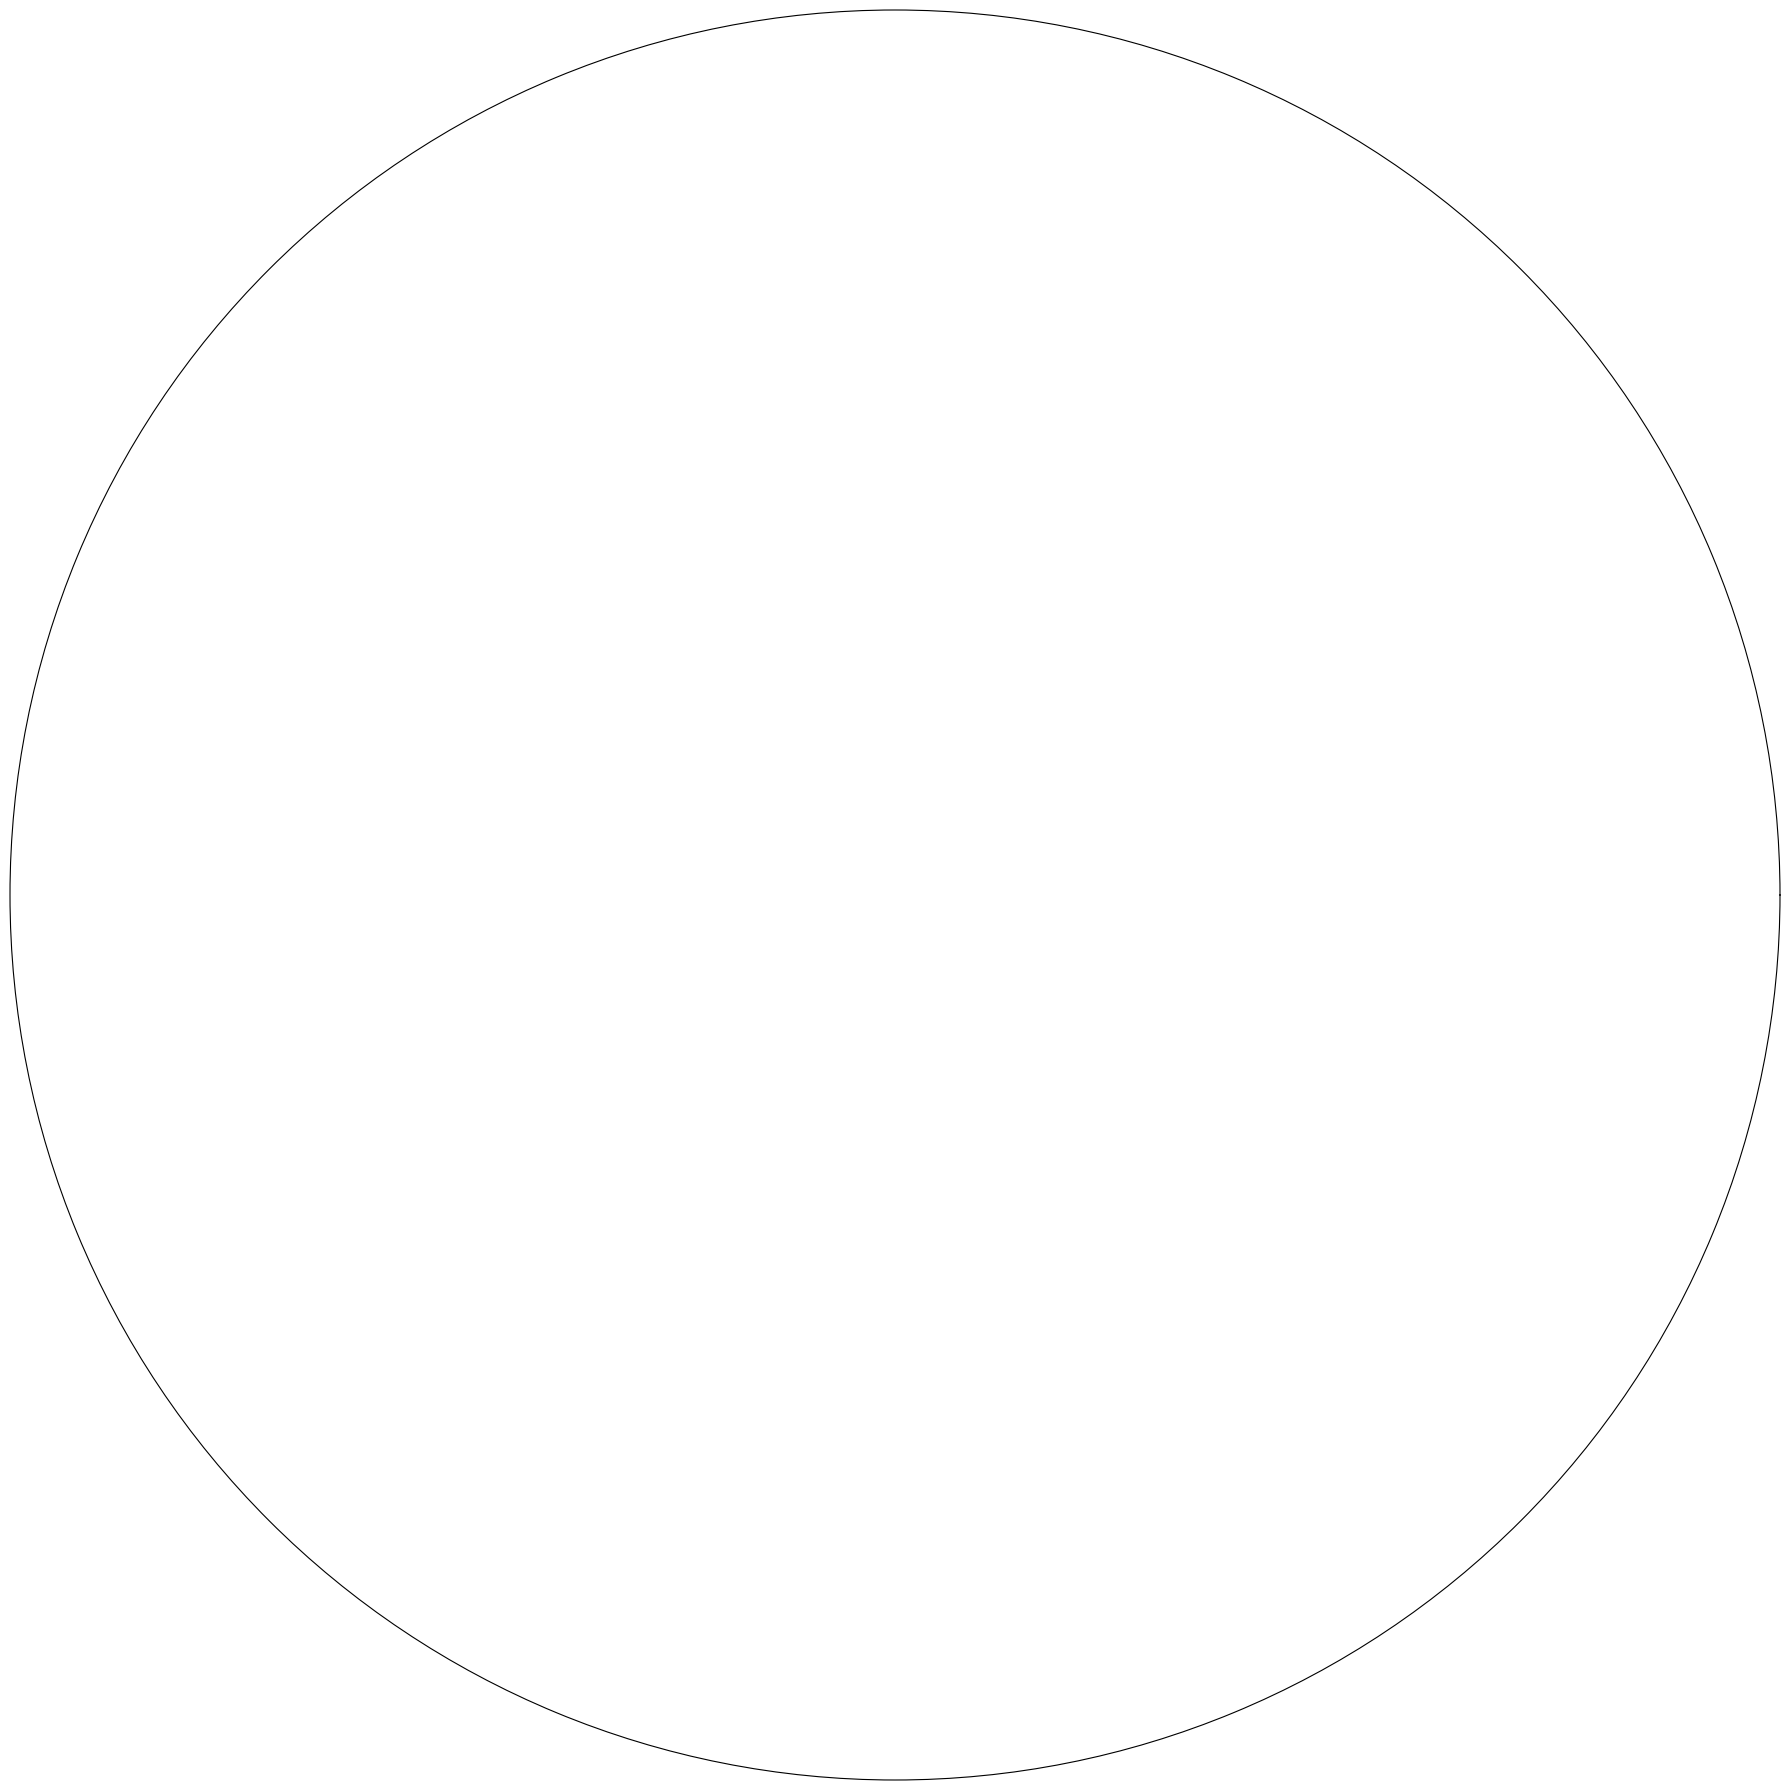

In [16]:
(params, opt_state), (valid_x, valid_y), (train_x, train_y) = (
    state,
    valid_data,
    train_data,
)
pred = (apply_fn(params, valid_x) > 0.5).astype(int)
vec = (pred + valid_y == 2).astype(int) * 2
src.polar_fn(vec, "predictions")
(pred + valid_y == 2).sum() / valid_y.sum()

In [20]:
apply_fn(params, train_x)

Array([-2.630012  , -0.93413645, -3.0267947 , ..., -1.1610519 ,
       -2.6118433 , -1.0884237 ], dtype=float32)

In [14]:
losses

Array([[0.13380334, 0.13692114],
       [0.13336873, 0.13647902],
       [0.13293537, 0.13603812],
       ...,
       [0.0196084 , 0.01796734],
       [0.0196077 , 0.01796752],
       [0.019607  , 0.01796771]], dtype=float32)